# MDP

# Gambler’s Problem – Value Iteration
Dieses Notebook ermöglicht es, das Spielerproblem interaktiv zu erforschen
Sie können die Wahrscheinlichkeit für Kopf (`p_head`) und den Tie-Break-Modus anpassen, um zu sehen, wie sich die optimale Wertfunktion und die Richtlinie ändern.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tabulate import tabulate

## Initialisierung
Hier werden alle Zustandswertfunktionen auf $v(s)=0$ gesetzt, außer die Zustandswertfunktion $v(100)=1$, da diese den Gewinnzustand darstellt.
Die Policy ist aktuell noch nicht bestimmt und ordnet jedem Zustand $s$ die Aktion $a=0$ zu. Das Zielkapital ist in der W-Seminararbeit auf 100€ festgesetzt.

In [4]:
tie_break_mode = ""
p_head = 0.5

In [5]:
goal = 100  # Zielkapital (in €)

def initialize_value_function(goal):
    V = np.zeros(goal + 1)
    V[goal] = 1.0
    return V

def initialize_policy(goal):
    return np.zeros(goal + 1, dtype=int)

V = initialize_value_function(goal)
policy = initialize_policy(goal)

## Iterative Aktualisierung
Durch wiederholte Anwendung der Bellman-Optimalitätsgleichung werden die Zustandswerte immer weiter aktualisiert, bis die Abweichung kleiner als die Toleranzgrenze $\theta$ ist.

In [7]:
def bellman(state, V, p_head):
    """
    Berechnet den Wert eines Zustands s nach der Bellman-Gleichung:
    
    V(s) = max_a [ p_head * V(s + a) + (1 - p_head) * V(s - a) ]
    """
    max_action = min(state, goal - state)
    action_values = np.zeros(max_action + 1)
    
    for action in range(1, max_action + 1):
        action_values[action] = p_head * V[state + action] + (1 - p_head) * V[state - action]
    
    return np.max(action_values)


def value_iteration(theta=1e-9):
    global V
    while True:
        V_new = V.copy()
        
        for state in range(1, goal):
            # Hier wird die Bellman-Gleichung direkt angewendet
            V_new[state] = bellman(state, V, p_head)
        
        delta = np.max(np.abs(V - V_new))
        V[:] = V_new
        if delta < theta:
            break
    
    return

## Bestimmen der optimalen Policy

Um die Optimale Policy zu bestimmen, muss man folgende Berechnung anstellen: $\pi^*(s) = \arg\max_{a \in A} \sum_{s'} P(s' \mid s, a) \big[ R(s, a, s') + \gamma V^*(s') \big]$.
Dabei gibt es für bestimmte Zustände $s$ mehrere Aktionen $a$, die denselben Gewinn liefern. Dies wird als Tie-Break bezeichnet. Mithilfe der Tie-Breaking-Strategie lassen sich hier diese Möglichkeiten simulieren:
- **Min**: Immer die kleinste Aktion wird gewählt, also der kleinste Einsatz des Spielers
- **Max**: Immer die größte Aktion wird gewählt, also der größte Einsatz des Spielers
- **Goal**: Es wird, wenn möglich, die Aktion/der Einsatz gewählt, der direkt zum Zielkapital führt
- **Random**: Es wird immer eine zufällige Aktion aus den möglichen optimalen Aktionen gewählt

In [9]:
def choose_best_action(vals, state, max_action):
    maxv = vals.max()
    candidates = np.where(vals == maxv)[0] + 1  # Aktionen 1..max_action mit maximalem Wert
    
    if tie_break_mode == "min":
        return candidates.min()
    elif tie_break_mode == "max":
        return candidates.max()
    elif tie_break_mode == "goal":
        # bevorzuge Aktion, die direkt zum Ziel führt
        direct = goal - state
        if direct in candidates:
            return direct
        else:
            return candidates.min()
    elif tie_break_mode == "random":
        return np.random.choice(candidates)
    else:
        raise ValueError(f"Unbekannter tie_break_mode: {tie_break_mode}")

def policy_iteration():
    for state in range(1, goal):
        max_action = min(state, goal - state)
        if max_action < 1:
            policy[state] = 0
            continue

        actions = np.arange(1, max_action + 1, dtype=float)
        vals = p_head * V[state + actions.astype(int)] + (1 - p_head) * V[state - actions.astype(int)]

        vals = np.round(vals, decimals=12)

        best_action = choose_best_action(vals, state, max_action)
        policy[state] = best_action
    return policy

## Hauptprogramm
Hier werden die optimalen Zustandswerte als auch die ideale Policy $\pi_*$ berechnet. Diese werden dann Als Diagramme gezeichnet. Duch die Widgets weiter unten lassen sich sowohl die Gewinnwahrscheinlichkeit $p_h$ als auch die Tie-Break-Strategie ändern.

In [11]:
tie_break_mode = "min"

In [12]:
p_head = 0.45

In [13]:
V_optimal = value_iteration()
policy_optimal = policy_iteration()

╒═══════════════╤═════════╤═══════════════════╕
│   Kapital (s) │   V*(s) │   π*(s) (Einsatz) │
╞═══════════════╪═════════╪═══════════════════╡
│             0 │   0     │                 0 │
├───────────────┼─────────┼───────────────────┤
│             1 │   0.005 │                 1 │
├───────────────┼─────────┼───────────────────┤
│             2 │   0.011 │                 2 │
├───────────────┼─────────┼───────────────────┤
│             3 │   0.017 │                 3 │
├───────────────┼─────────┼───────────────────┤
│             4 │   0.023 │                 4 │
├───────────────┼─────────┼───────────────────┤
│             5 │   0.03  │                 5 │
├───────────────┼─────────┼───────────────────┤
│             6 │   0.038 │                 6 │
├───────────────┼─────────┼───────────────────┤
│             7 │   0.045 │                 7 │
├───────────────┼─────────┼───────────────────┤
│             8 │   0.052 │                 8 │
├───────────────┼─────────┼─────────────

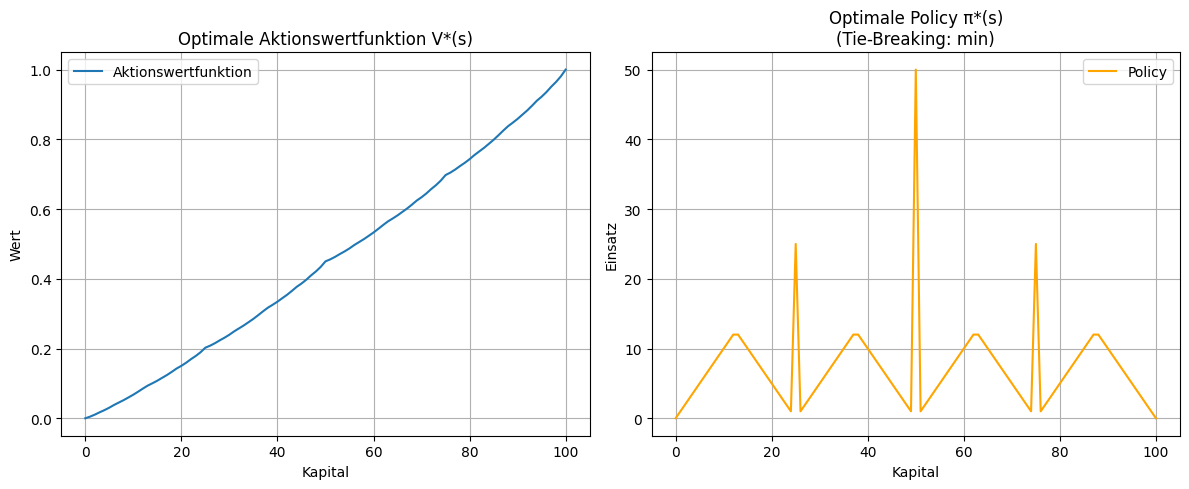

In [14]:
# Use V and policy directly since value_iteration and policy_iteration modify them in place
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(range(goal + 1), V, label='Aktionswertfunktion')
axes[0].set_xlabel('Kapital')
axes[0].set_ylabel('Wert')
axes[0].set_title('Optimale Aktionswertfunktion V*(s)')
axes[0].grid(True)
axes[0].legend()

axes[1].plot(range(goal + 1), policy, label='Policy', color='orange')
axes[1].set_xlabel('Kapital')
axes[1].set_ylabel('Einsatz')
axes[1].set_title(f'Optimale Policy π*(s)\n(Tie-Breaking: {tie_break_mode})')
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()

data = {
    "Kapital (s)": np.arange(goal + 1),
    "V*(s)": np.round(V, 3),
    "π*(s) (Einsatz)": policy
}

df = pd.DataFrame(data)

# Display as a pretty Markdown-style table
print(tabulate(df, headers='keys', tablefmt='fancy_grid', showindex=False))